In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_pred, target):
    # Step 1: Create confusion matrix
    confusion_df = pd.DataFrame({'True Label': target, 'Predicted Cluster': y_pred})
    confusion = confusion_df.value_counts().unstack(fill_value=0)
    confusion.columns = ['Cluster ' + str(i + 1) for i in confusion.columns]
    confusion.index.name = 'True Label'

    # Step 2: Row-wise percentages (per true label)
    row_totals = confusion.sum(axis=1).replace(0, np.nan)  # Avoid divide-by-zero
    perc_matrix = np.round(confusion.div(row_totals, axis=0) * 100, 1)

    # Step 3: Combine counts + percentages into labels
    combined = pd.DataFrame('', index=confusion.index, columns=confusion.columns)
    for row in confusion.index:
        for col in confusion.columns:
            count = confusion.loc[row, col]
            perc = perc_matrix.loc[row, col]
            combined.loc[row, col] = f'{count} ({perc}%)'

    # Step 4: Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(perc_matrix, annot=combined, fmt='', cmap='Blues', cbar=True)
    plt.title('Confusion Matrix: Cluster vs True Labels\n(Counts and Row-wise Percentages)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Cluster')
    plt.tight_layout()
    plt.show()


Question -1 (a) K-Means Clustering and Dimensionality Reduction

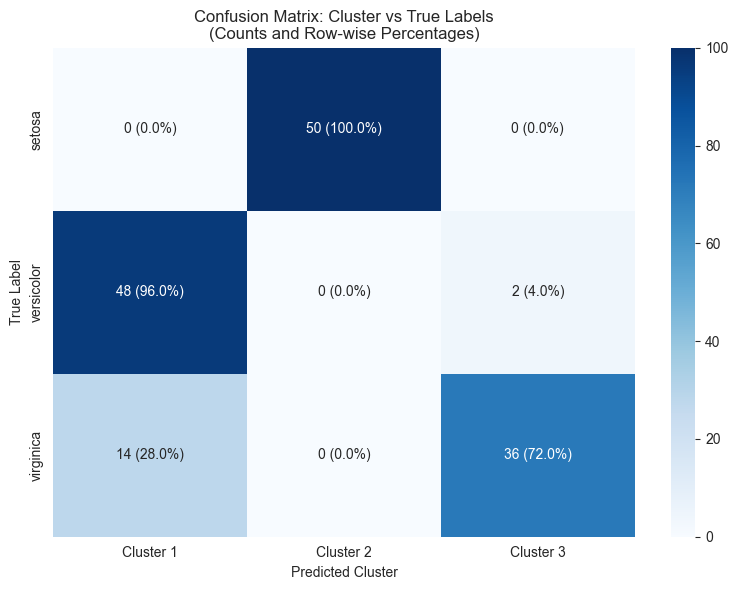

89.33333333333333


In [9]:
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt
#1(a)
iris = load_iris(as_frame=True)
X = iris.data
y_true = iris.target

target = iris.target.map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# print(X)
# print(y_true)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X)
plot_confusion_matrix(y_pred, target)

labels_counter = np.zeros_like(y_pred)
for i in range(3):
    mask = (y_pred == i)
    most_common = Counter(y_true[mask]).most_common(1)[0][0]
    labels_counter[mask] = most_common

accuracy_counter = np.mean(labels_counter == y_true) * 100
print(accuracy_counter)


Question- 1(b)

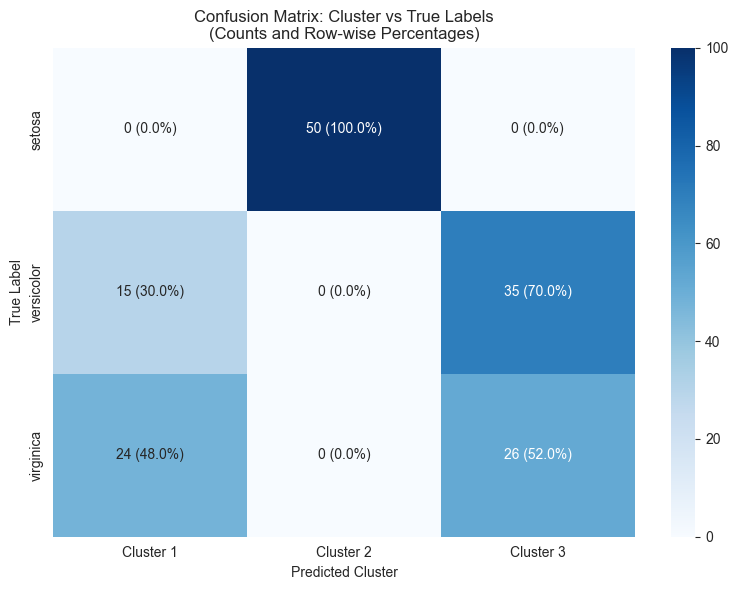

72.66666666666667


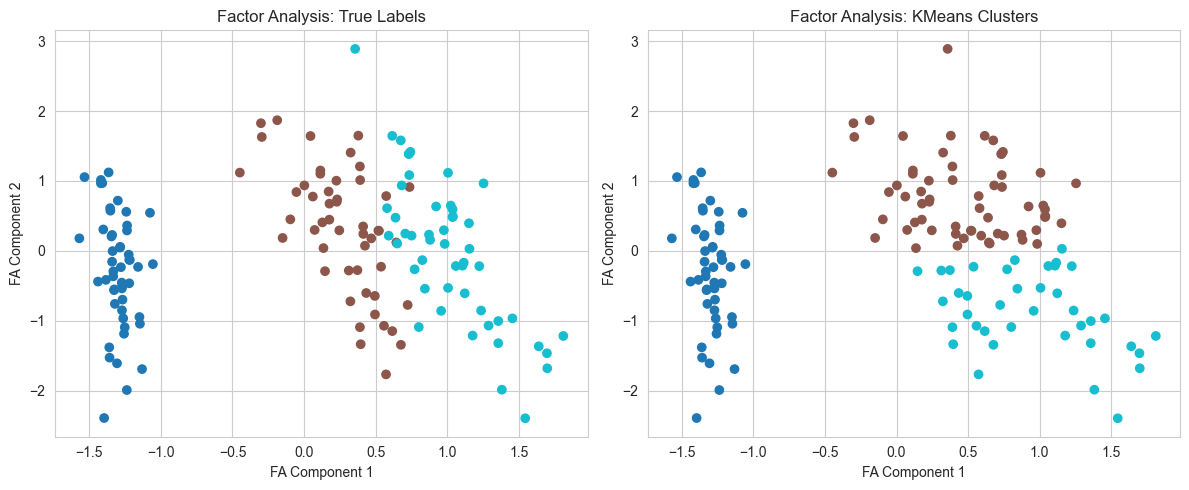

In [10]:
#1(b)
fa = FactorAnalysis(n_components=2, random_state=42)
X_fa = fa.fit_transform(X)

kmeans_fa = KMeans(n_clusters=3, random_state=42, n_init= 10)
y_pred_fa = kmeans_fa.fit_predict(X_fa)

plot_confusion_matrix(y_pred_fa, target)
labels_counter_fa = np.zeros_like(y_pred_fa)
for i in range(3):
    mask = (y_pred_fa == i)
    most_common = Counter(y_true[mask]).most_common(1)[0][0]
    labels_counter_fa[mask] = most_common
    
accuracy_counter_fa = np.mean(labels_counter_fa == y_true) * 100
print(accuracy_counter_fa)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot true labels
ax1.scatter(X_fa[:, 0], X_fa[:, 1], c=y_true, cmap='tab10')
ax1.set_title("Factor Analysis: True Labels")
ax1.set_xlabel("FA Component 1")
ax1.set_ylabel("FA Component 2")

# Plot cluster labels
ax2.scatter(X_fa[:, 0], X_fa[:, 1], c=labels_counter_fa, cmap='tab10')
ax2.set_title("Factor Analysis: KMeans Clusters")
ax2.set_xlabel("FA Component 1")
ax2.set_ylabel("FA Component 2")

plt.savefig('1_a', bbox_inches='tight')
plt.tight_layout()
plt.show()
    


Question 2 (a) - Minimum Spanning Tree Clustering on LungA Dataset

(3312, 203)


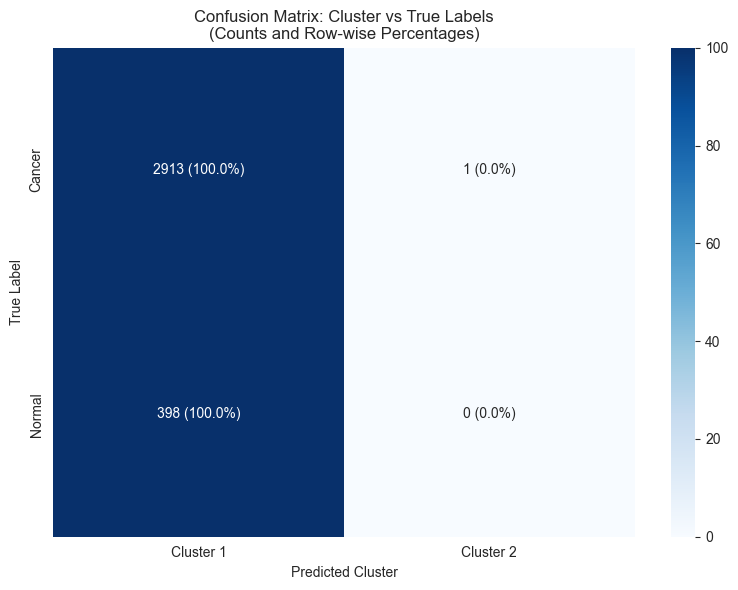

In [11]:
# Final version of the MST clustering code for genes using LungA.mat
#2 (a)
import scipy.io
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
from collections import Counter

# Step 1: Load .mat file
mat_path = 'lungA.mat'
mat_contents = scipy.io.loadmat(mat_path)

# Step 2: Extract gene expression data and labels
X_raw = mat_contents['lungA']
label_nested = mat_contents['labA']
labels_flat = [item[0] for item in label_nested[0]]  # flatten label array

print(X_raw.shape)

# Step 3: Create binary sample labels: 0 = Normal, 1 = Cancer (SMCL + AD + SQ + COID)
binary_sample_labels = np.array(['Normal' if label == 'NL' else 'Cancer' for label in labels_flat])

# Step 4: Assign each gene a label: 0 if mostly expressed in Normal, 1 if mostly in Cancer
gene_labels = []
for gene_expression in X_raw:
    normal_expr = gene_expression[np.array(labels_flat) == 'NL']
    cancer_expr = gene_expression[np.array(labels_flat) != 'NL']
    gene_label = 'Normal' if np.mean(normal_expr) > np.mean(cancer_expr) else 'Cancer'
    gene_labels.append(gene_label)
gene_labels = np.array(gene_labels)

# Step 5: Standardize genes
X_genes_scaled = StandardScaler().fit_transform(X_raw)

# Step 6: Construct MST based on pairwise distances
gene_dist_matrix = squareform(pdist(X_genes_scaled, metric='euclidean'))
gene_mst_sparse = minimum_spanning_tree(gene_dist_matrix)
gene_mst_dense = gene_mst_sparse.toarray()

# Step 7: Build graph and remove largest edge to create 2 clusters
G_gene = nx.from_numpy_array(gene_mst_dense)
largest_edge = max(G_gene.edges(data=True), key=lambda x: x[2]['weight'])
G_gene.remove_edge(largest_edge[0], largest_edge[1])

# Step 8: Extract MST-based clusters
components = list(nx.connected_components(G_gene))
cluster_labels_genes = np.zeros(X_raw.shape[0], dtype=int)
for idx, component in enumerate(components):
    for node in component:
        cluster_labels_genes[node] = idx

plot_confusion_matrix(cluster_labels_genes, gene_labels)


Question - 2(b)

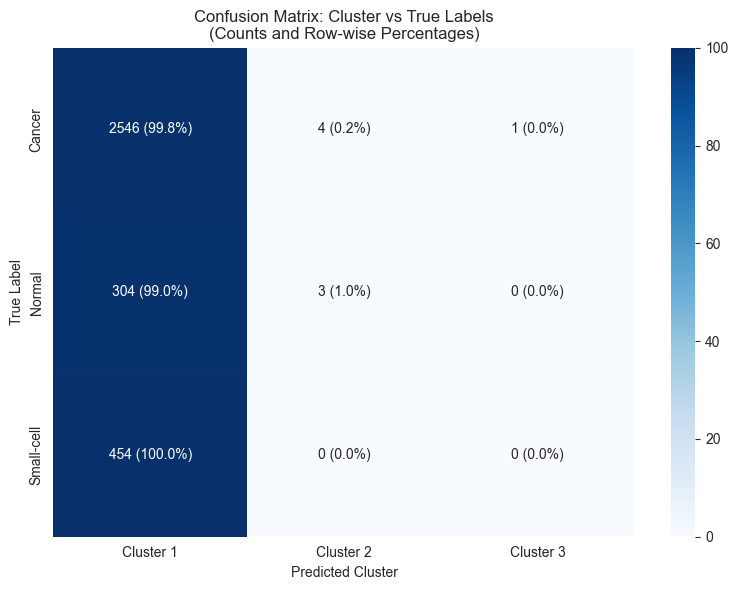

In [12]:
# Step 1: Rebuild 3-class gene labels based on majority expression
#2(b)
gene_labels_3class = []
for gene_expression in X_raw:
    expr_NL = np.mean(gene_expression[np.array(labels_flat) == 'NL'])
    expr_SMCL = np.mean(gene_expression[np.array(labels_flat) == 'SMCL'])
    expr_NonSmall = np.mean(gene_expression[np.isin(labels_flat, ['AD', 'SQ', 'COID'])])

    # Determine which group has the highest average expression
    max_expr = max(expr_NL, expr_SMCL, expr_NonSmall)
    if max_expr == expr_NL:
        gene_labels_3class.append('Normal')  # Normal
    elif max_expr == expr_SMCL:
        gene_labels_3class.append('Cancer')  # Small-cell lung carcinoma
    else:
        gene_labels_3class.append('Small-cell')  # Non-small cell lung carcinoma

gene_labels_3class = np.array(gene_labels_3class)

# Step 2: Reuse MST from earlier
G_gene = nx.from_numpy_array(gene_mst_dense)

# Step 3: Remove two largest edges to make 3 clusters
sorted_edges = sorted(G_gene.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
G_gene.remove_edge(sorted_edges[0][0], sorted_edges[0][1])
G_gene.remove_edge(sorted_edges[1][0], sorted_edges[1][1])

# Step 4: Extract 3 clusters
components = list(nx.connected_components(G_gene))
cluster_labels_3 = np.zeros(X_raw.shape[0], dtype=int)
for idx, component in enumerate(components):
    for node in component:
        cluster_labels_3[node] = idx
        
        


plot_confusion_matrix(cluster_labels_3, gene_labels_3class)



Question - 2(c)

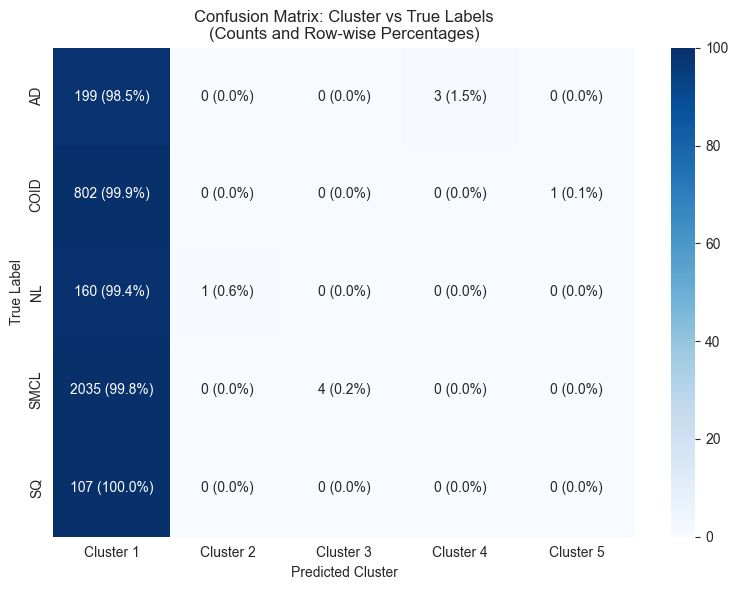

In [13]:
# Step 1: Assign 5-class labels to genes based on dominant expression

gene_labels_5class = []
for gene_expression in X_raw:
    expr_dict = {
        'AD': np.mean(gene_expression[np.array(labels_flat) == 'AD']),
        'COID': np.mean(gene_expression[np.array(labels_flat) == 'COID']),
        'SQ': np.mean(gene_expression[np.array(labels_flat) == 'SQ']),
        'NL': np.mean(gene_expression[np.array(labels_flat) == 'NL']),
        'SMCL': np.mean(gene_expression[np.array(labels_flat) == 'SMCL']),
    }
    max_label = max(expr_dict, key=expr_dict.get)
    gene_labels_5class.append(max_label)

# Convert labels to integers
label_map_5 = {'AD': 0, 'COID': 1, 'SQ': 2, 'NL': 3, 'SMCL': 4}
gene_labels_5class_int = np.array([label for label in gene_labels_5class])

# Step 2: Build MST
gene_dist_matrix = squareform(pdist(X_genes_scaled, metric='euclidean'))
gene_mst_sparse = minimum_spanning_tree(gene_dist_matrix)
gene_mst_dense = gene_mst_sparse.toarray()
G_gene = nx.from_numpy_array(gene_mst_dense)

# Step 3: Remove 4 largest edges for 5 clusters
sorted_edges = sorted(G_gene.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
for i in range(4):
    G_gene.remove_edge(sorted_edges[i][0], sorted_edges[i][1])

# Step 4: Extract cluster labels
components = list(nx.connected_components(G_gene))
cluster_labels_5 = np.zeros(X_raw.shape[0], dtype=int)
for idx, component in enumerate(components):
    for node in component:
        cluster_labels_5[node] = idx

plot_confusion_matrix(cluster_labels_5, gene_labels_5class_int)

# # Step 5: Remap clusters to true labels using majority vote
# mapped_clusters_5 = np.zeros_like(cluster_labels_5)
# for i in range(5):
#     mask = (cluster_labels_5 == i)
#     most_common = Counter(gene_labels_5class_int[mask]).most_common(1)[0][0]
#     mapped_clusters_5[mask] = most_common
# 
# # Step 6: Compute accuracy
# accuracy_5class = np.mean(mapped_clusters_5 == gene_labels_5class_int) * 100
# print(accuracy_5class)


Quesiton - 3 

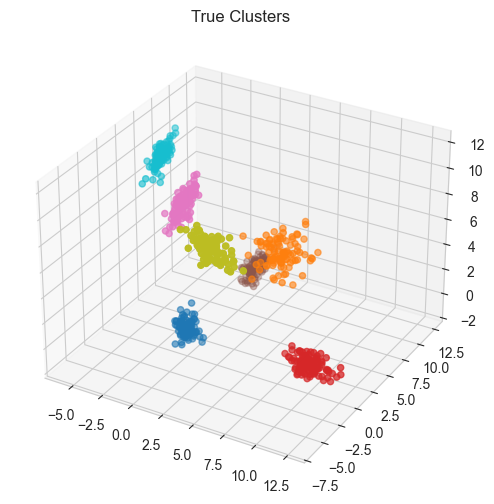


Best Model:
 - Covariance Type: full
 - Components: 7
 - BIC Score: 6435.06
Adjusted Rand Index (ARI): 1.0000
Confusion Matrix:
[[  0   0 100   0   0   0   0]
 [  0   0   0   0 100   0   0]
 [100   0   0   0   0   0   0]
 [  0   0   0   0   0 100   0]
 [  0   0   0   0   0   0 100]
 [  0   0   0 100   0   0   0]
 [  0 100   0   0   0   0   0]]


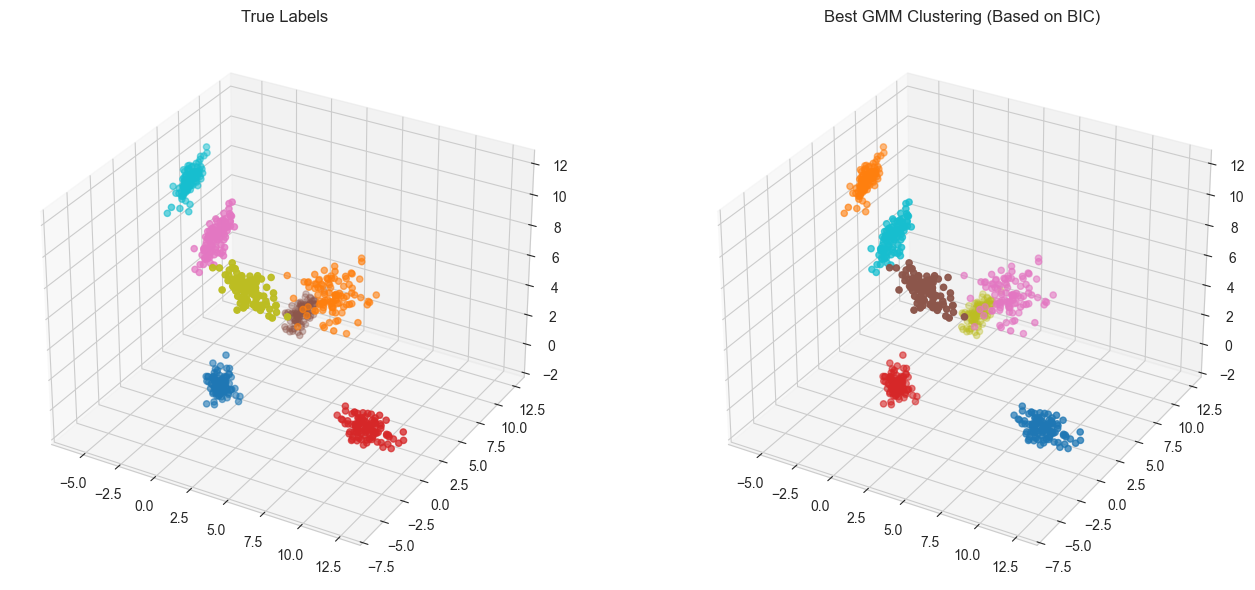

In [14]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix
from scipy.spatial.transform import Rotation as R
from collections import Counter

# Helper functions to generate clusters
def generate_ball(center, radius, n_samples):
    return np.random.normal(loc=center, scale=radius, size=(n_samples, 3))

def generate_ellipsoid(center, scales, n_samples):
    return np.random.normal(scale=scales, size=(n_samples, 3)) + center

def generate_rotated_ellipsoid(center, scales, n_samples):
    points = np.random.normal(scale=scales, size=(n_samples, 3))
    rot = R.random().as_matrix()
    return points @ rot.T + center

# Set seed and generate clusters
np.random.seed(42)
X_list, y_list = [], []
label = 0

#two balls of dierent sizes
X_list.append(generate_ball([0, 0, 0], 0.5, 100))
y_list.append(np.full(100, label)); label += 1
X_list.append(generate_ball([5, 5, 5], 1.0, 100))
y_list.append(np.full(100, label)); label += 1

#two ellipsoids of dierent size with symmetry axis parallel with coordinates axis
X_list.append(generate_ellipsoid([10, 0, 0], [1.0, 0.2, 0.5], 100))
y_list.append(np.full(100, label)); label += 1
X_list.append(generate_ellipsoid([0, 10, 0], [0.3, 1.0, 0.4], 100))
y_list.append(np.full(100, label)); label += 1

# three ellipsoids also dierent sizes with arbitrary symmetry axis
X_list.append(generate_rotated_ellipsoid([0, 0, 10], [1.0, 0.2, 0.5], 100))
y_list.append(np.full(100, label)); label += 1
X_list.append(generate_rotated_ellipsoid([5, -5, 10], [0.5, 1.0, 0.3], 100))
y_list.append(np.full(100, label)); label += 1
X_list.append(generate_rotated_ellipsoid([-5, 5, 10], [0.3, 0.3, 1.2], 100))
y_list.append(np.full(100, label)); label += 1

# Combine data
X = np.vstack(X_list)
y_true = np.concatenate(y_list)


# 2. Visualize
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_true, cmap='tab10')
plt.title("True Clusters")
plt.show()


# 3. Apply model-based clustering (Gaussian Mixture) using BIC
lowest_bic = np.inf
best_model = None
best_labels = None

cov_types = ['full', 'tied', 'diag', 'spherical']
bic_scores = []

for cov in cov_types:
    for n_comp in range(1, 11):
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov, random_state=42)
        gmm.fit(X)
        bic = gmm.bic(X)
        bic_scores.append((bic, cov, n_comp))
        if bic < lowest_bic:
            lowest_bic = bic
            best_model = gmm
            best_labels = gmm.predict(X)

print(f"\nBest Model:")
print(f" - Covariance Type: {best_model.covariance_type}")
print(f" - Components: {best_model.n_components}")
print(f" - BIC Score: {lowest_bic:.2f}")

# 4. Evaluate
ari = adjusted_rand_score(y_true, best_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_true, best_labels))

# 5. Visualization
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_true, cmap='tab10')
ax1.set_title("True Labels")

ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=best_labels, cmap='tab10')
ax2.set_title("Best GMM Clustering (Based on BIC)")

plt.tight_layout()
plt.savefig('3_a', bbox_inches='tight')
plt.show()




Best Model (with Overlap):
 - Covariance Type: full
 - Components: 6
 - BIC Score: 6983.10
Adjusted Rand Index (ARI): 0.5260
Confusion Matrix:
[[70  3  3  3  2 19  0]
 [33  5 34  3 16  9  0]
 [94  5  0  0  0  1  0]
 [ 9  0  0  0  0 91  0]
 [ 1  9  0  1 88  1  0]
 [ 6 91  0  0  3  0  0]
 [ 0  0  0 98  0  2  0]]


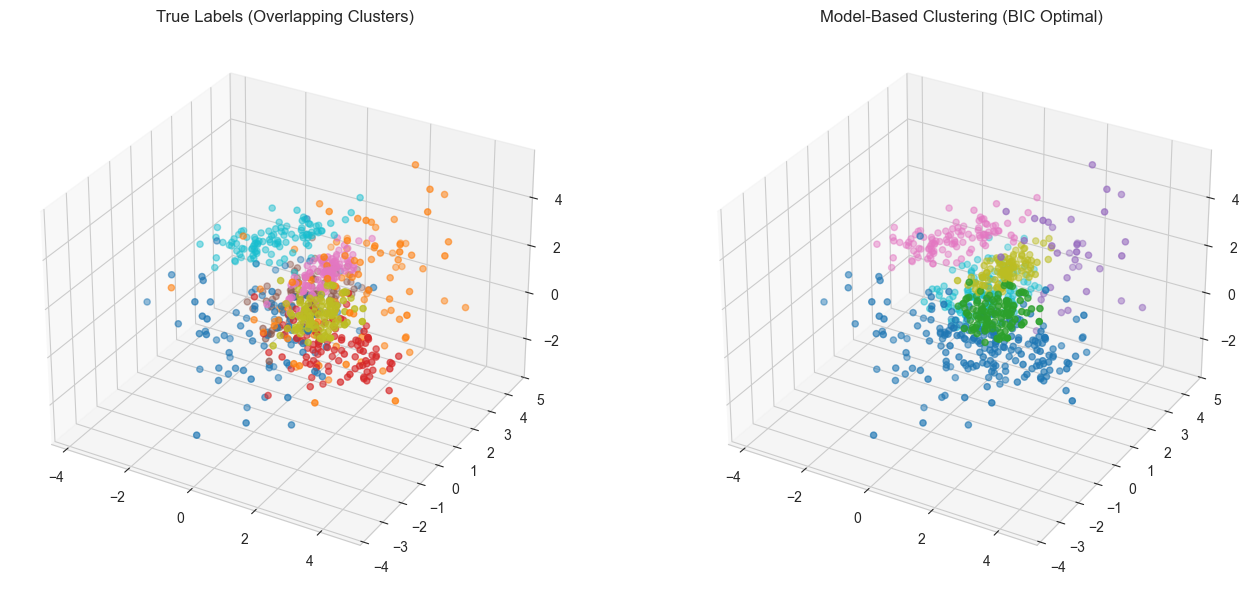

In [15]:
# Generate overlapping 3D clusters
np.random.seed(123)
X_list, y_list = [], []
label = 0

# Two balls (closer centers)
X_list.append(generate_ball([0, 0, 0], 1.2, 100)); y_list.append(np.full(100, label)); label += 1
X_list.append(generate_ball([1.5, 1.5, 1.5], 1.5, 100)); y_list.append(np.full(100, label)); label += 1

# Two axis-aligned ellipsoids (closer)
X_list.append(generate_ellipsoid([2, 0, 0], [1.0, 0.5, 0.7], 100)); y_list.append(np.full(100, label)); label += 1
X_list.append(generate_ellipsoid([0, 2, 0], [0.6, 1.0, 0.4], 100)); y_list.append(np.full(100, label)); label += 1

# Three rotated ellipsoids (moderate spacing)
X_list.append(generate_rotated_ellipsoid([1, 1, 2], [1.0, 0.3, 0.5], 100)); y_list.append(np.full(100, label)); label += 1
X_list.append(generate_rotated_ellipsoid([2, -1, 2], [0.5, 1.0, 0.4], 100)); y_list.append(np.full(100, label)); label += 1
X_list.append(generate_rotated_ellipsoid([-1, 2, 2], [0.4, 0.4, 1.0], 100)); y_list.append(np.full(100, label)); label += 1

# Combine
X_overlap = np.vstack(X_list)
y_true_overlap = np.concatenate(y_list)

# 3. Apply model-based clustering (Gaussian Mixture) using BIC
X = X_overlap
y_true = y_true_overlap

best_bic = np.inf
best_model = None
best_labels = None

cov_types = ['full', 'tied', 'diag', 'spherical']

for cov in cov_types:
    for n_comp in range(1, 11):
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov, random_state=42)
        gmm.fit(X)
        bic = gmm.bic(X)
        if bic < best_bic:
            best_bic = bic
            best_model = gmm
            best_labels = gmm.predict(X)

print(f"\nBest Model (with Overlap):")
print(f" - Covariance Type: {best_model.covariance_type}")
print(f" - Components: {best_model.n_components}")
print(f" - BIC Score: {best_bic:.2f}")

# 4. Evaluate performance
ari = adjusted_rand_score(y_true, best_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_true, best_labels))

# 5. Visualization
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_true, cmap='tab10')
ax1.set_title("True Labels (Overlapping Clusters)")

ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=best_labels, cmap='tab10')
ax2.set_title("Model-Based Clustering (BIC Optimal)")

plt.tight_layout()
plt.savefig('3_b', bbox_inches='tight')
plt.show()



Question No: 4 - 

0.4820550842010172


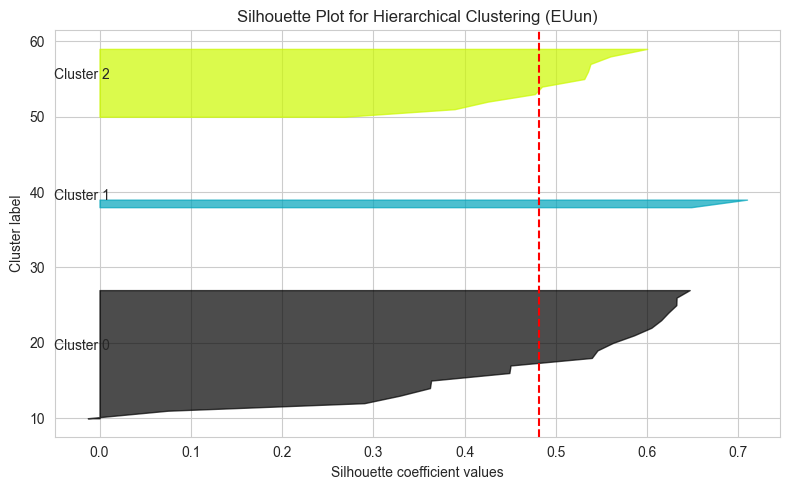

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

EUun = pd.read_excel("unemployment.xlsx", sheet_name="actual", index_col=0)
EUin = pd.read_excel("inflation.xlsx", sheet_name="actual", index_col=0)

# Use only common countries
common_countries = EUun.index.intersection(EUun.index)
EUun_clean = EUun.loc[common_countries]
EUin_clean = EUin.loc[common_countries]

X_un = EUun_clean
X_un_scaled = StandardScaler().fit_transform(X_un)

n_clusters = 3
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = model.fit_predict(X_un_scaled)

silhouette_vals = silhouette_samples(X_un_scaled, labels)
avg_silhouette = silhouette_score(X_un_scaled, labels)
print(avg_silhouette)

# Plot silhouette scores
fig, ax = plt.subplots(figsize=(8, 5))
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = silhouette_vals[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    y_lower = y_upper + 10

ax.set_title("Silhouette Plot for Hierarchical Clustering (EUun)")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.axvline(x=avg_silhouette, color="red", linestyle="--")
plt.tight_layout()
plt.savefig('4_a', bbox_inches='tight')
plt.show()


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Prepare full dataset EU = [EUin, EUun]
EU = pd.merge(EUin_clean, EUun_clean, left_index=True, right_index=True, suffixes=('_inflation', '_unemployment'))

print(EU)

# Standardize
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(EU.values)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X)

# Compute Dunn index
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    intra_dists = []
    inter_dists = []

    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            intra = np.max(pairwise_distances(cluster_points))
            intra_dists.append(intra)

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]
            inter = np.min(pairwise_distances(cluster_i, cluster_j))
            inter_dists.append(inter)

    return np.min(inter_dists) / np.max(intra_dists)

dunn = dunn_index(X, labels)
print(dunn)


             2015  2016  2017  2018  2019  2020  2021  2022  2023  2024  2015  \
TIME                                                                            
Belgium       0.6   1.8   2.2   2.3   1.2   0.4   3.2  10.3   2.3   4.3   8.7   
Bulgaria     -1.1  -1.3   1.2   2.6   2.5   1.2   2.8  13.0   8.6   2.6  10.1   
Czechia       0.3   0.6   2.4   2.0   2.6   3.3   3.3  14.8  12.0   2.7   5.1   
Denmark       0.2   0.0   1.1   0.7   0.7   0.3   1.9   8.5   3.4   1.3   6.3   
Germany       0.7   0.4   1.7   1.9   1.4   0.4   3.2   8.7   6.0   2.5   4.4   
Estonia       0.1   0.8   3.7   3.4   2.3  -0.6   4.5  19.4   9.1   3.7   6.4   
Ireland       0.0  -0.2   0.3   0.7   0.9  -0.5   2.4   8.1   5.2   1.3   9.9   
Greece       -1.1   0.0   1.1   0.8   0.5  -1.3   0.6   9.3   4.2   3.0  25.0   
Spain        -0.6  -0.3   2.0   1.7   0.8  -0.3   3.0   8.3   3.4   2.9  22.1   
France        0.1   0.3   1.2   2.1   1.3   0.5   2.1   5.9   5.7   2.3  10.3   
Croatia      -0.3  -0.6   1.

Question 5

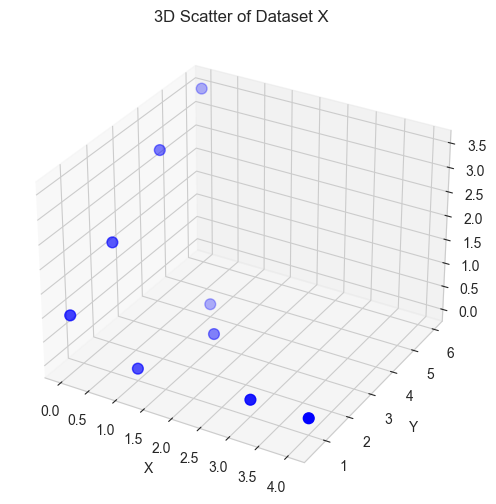

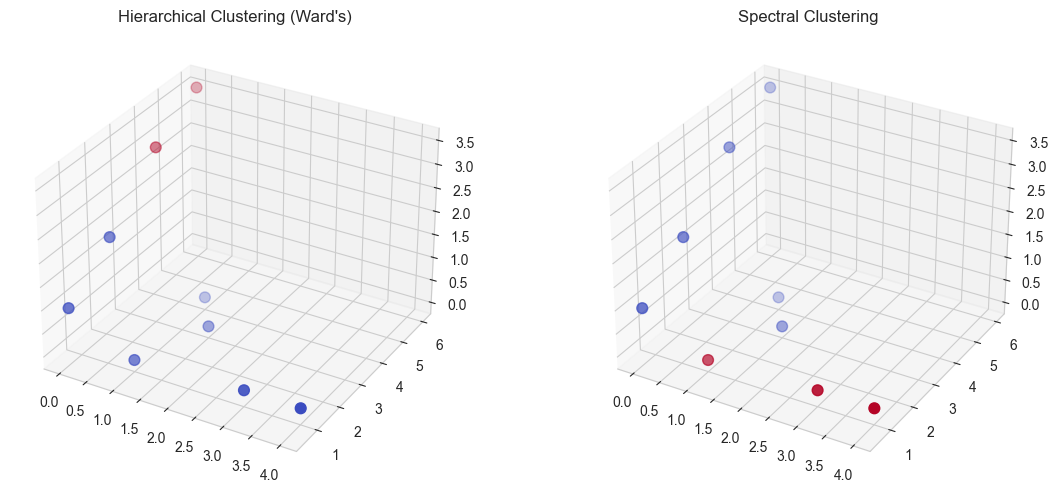

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

# 1. Dataset (from X^T)
X = np.array([
    [3,    1,   0.1 ],
    [1,    4,   0.02],
    [1,    1,   0.0 ],
    [4,    1,   0.1 ],
    [1.5,  3,   0.0 ],
    [0.12, 2,   1.9 ],
    [0.0,  6,   3.5 ],
    [0.03, 0.5, 1.0 ],
    [0.1,  4,   3.0 ]
])

# 2. 3D Scatter Plot
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', s=60)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter of Dataset X')
plt.savefig('5_a', bbox_inches='tight')
plt.show()

# 3. Ward's Hierarchical Clustering
ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_ward = ward.fit_predict(X)

# 4. Spectral Clustering
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=3, random_state=42)
labels_spectral = spectral.fit_predict(X)

# 5. Plot both clustering results
fig = plt.figure(figsize=(12, 5))

# Ward's
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels_ward, cmap='coolwarm', s=60)
ax1.set_title("Hierarchical Clustering (Ward's)")

# Spectral
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels_spectral, cmap='coolwarm', s=60)
ax2.set_title("Spectral Clustering")

plt.tight_layout()
plt.savefig('5_b', bbox_inches='tight')
plt.show()



Question - 6(A)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
XT = np.array([
    [3, 1, 1, 4, 1.5, 0.12, 0, 0.03, 0.1],
    [1, 4, 1, 1, 3, 2, 6, 0.5, 4],
    [0.1, 0.02, 0, 0.1, 0, 1.9, 3.5, 1, 3]
])

X = XT.T

rank = 3
nmf_model = NMF(n_components=rank, solver='mu', max_iter=1000, random_state=10)
W = nmf_model.fit_transform(X)
H = nmf_model.components_


print("W (9x3):\n", W)
print("\nH (3x3):\n", H)


W (9x3):
 [[3.74901344e-02 9.05003466e-01 7.27053659e-02]
 [1.04022217e-02 2.88480508e-01 9.14679589e-01]
 [7.33794767e-04 2.99189473e-01 1.92810850e-01]
 [3.64835318e-02 1.20768753e+00 2.42710485e-02]
 [3.86653922e-03 4.43431430e-01 6.51362270e-01]
 [7.82113388e-01 4.06503501e-02 1.02839066e-05]
 [1.39063533e+00 7.95856184e-08 6.34106005e-01]
 [3.04936604e-01 1.21419870e-19 2.00775597e-46]
 [1.19312372e+00 2.66760980e-02 2.61334006e-01]]

H (3x3):
 [[2.41406695e-30 2.42694889e+00 2.52019693e+00]
 [3.31094824e+00 6.73005819e-01 4.39329622e-03]
 [4.80777852e-02 4.13442489e+00 2.22454489e-16]]


Question - 6 (b) 

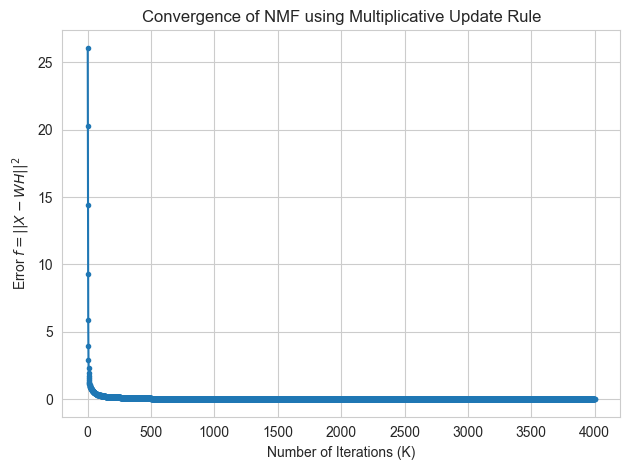

Last error after 4000 iteration 6.009116577875831e-07
Minimum K where error f < 1e-4: 942


In [20]:
import warnings
from sklearn.exceptions import ConvergenceWarning
max_iter = 4000
errors = []
tolerance = 1e-4
optimal_K = None
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    for K in range(1, max_iter + 1):
        model = NMF(solver='mu', max_iter=K, random_state=10, tol=np.finfo(np.float32).eps)
        W = model.fit_transform(X)
        H = model.components_
        
        error = np.linalg.norm(X - np.dot(W, H))**2
        errors.append(error)
        
        if error < tolerance and optimal_K is None:
            optimal_K = K

plt.plot(range(1, max_iter + 1), errors, marker='o', markersize=3)
plt.xlabel("Number of Iterations (K)")
plt.ylabel("Error $f = ||X - WH||^2$")
plt.title("Convergence of NMF using Multiplicative Update Rule")
plt.grid(True)
plt.tight_layout()
plt.savefig('6_b', bbox_inches='tight')
plt.show()

print(f"Last error after {K} iteration {errors.pop()}")

if optimal_K:
    print(f"Minimum K where error f < 1e-4: {optimal_K}")
else:
    print(f"Error did not drop below 1e-4 within {K} iterations.")

Question 8

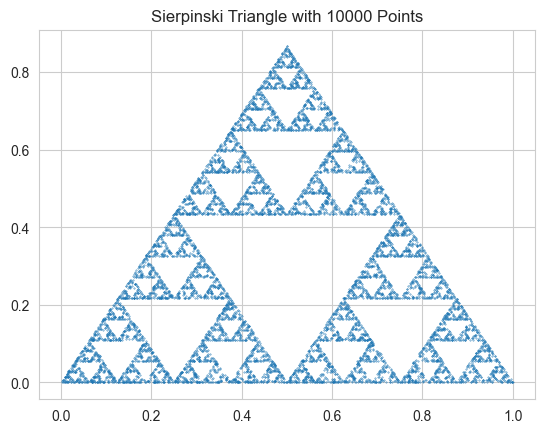

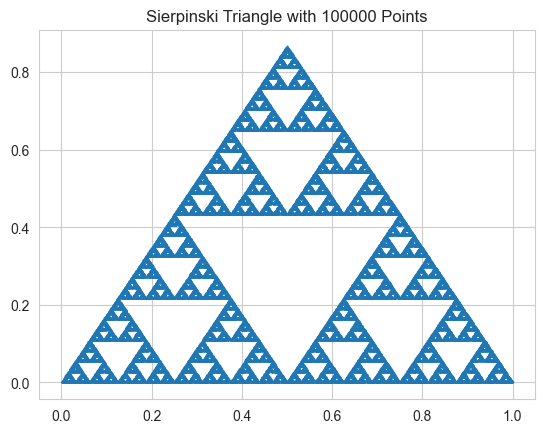

Estimated intrinsic dimensionality with 10000 points: 1.7524533576573234
Estimated intrinsic dimensionality with 100000 points: 1.7378390960984733


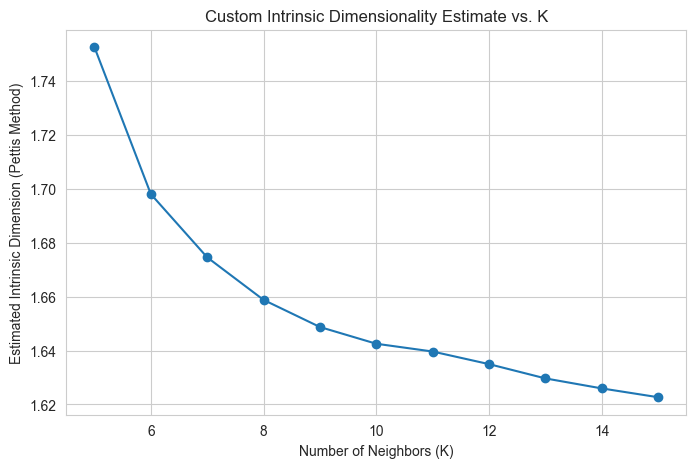

In [21]:
from sklearn.neighbors import NearestNeighbors
from scipy.special import gammaln
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
# from pyEDAkit import IntrinsicDimensionality

# Function to generate points in the Sierpinski triangle
def generate_sierpinski_points(n_points):
    points = np.zeros((n_points, 2))
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    points[0] = vertices[np.random.choice([0, 1, 2])]
    
    for i in range(1, n_points):
        points[i] = (points[i-1] + vertices[np.random.choice([0, 1, 2])]) / 2
    
    return points


#copied from pyEDAKit
#small change like additon of sklearn NearestNeighbors and k value

def id_pettis(X, k=5, robust=True):
    n = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(X)
    distances, _ = nbrs.kneighbors(X)
    kdist = distances[:, 1:]  # skip self-distance

    mmax = np.mean(kdist[:, -1])
    smax = np.std(kdist[:, -1])

    logrk = []
    for i in range(k):
        dists_i = kdist[:, i]

        if robust:
            mask = dists_i <= (mmax + smax)
            dists_i = dists_i[mask]

        mean_dist = np.mean(dists_i)
        logrk.append(np.log(mean_dist))

    logk = np.log(np.arange(1, k + 1))
    logrk = np.array(logrk)

    # Initial slope estimate
    p_coeffs = Polynomial.fit(logk, logrk, 1).convert().coef
    dhat = 1 / p_coeffs[1]

    # Iterative refinement
    max_iter = 100
    eps = 0.01
    for _ in range(max_iter):
        logGRk = (1 / dhat) * logk + gammaln(np.arange(1, k + 1)) - gammaln(np.arange(1, k + 1) + 1 / dhat)
        p_coeffs = Polynomial.fit(logk, logrk + logGRk, 1).convert().coef
        dhat_new = 1 / p_coeffs[1]

        if abs(dhat - dhat_new) < eps:
            break
        dhat = dhat_new

    return dhat

# Generate and plot 10000 points
points_10000 = generate_sierpinski_points(10000)
plt.scatter(points_10000[:, 0], points_10000[:, 1], s=0.1)
plt.title("Sierpinski Triangle with 10000 Points")
plt.savefig('8_b_1', bbox_inches='tight')
plt.show()

# Generate and plot 100000 points
points_100000 = generate_sierpinski_points(100000)
plt.scatter(points_100000[:, 0], points_100000[:, 1], s=0.1)
plt.title("Sierpinski Triangle with 100000 Points")
plt.savefig('8_b_2', bbox_inches='tight')
plt.show()

# Estimate intrinsic dimensionality
intrinsic_dim_10000 = id_pettis(points_10000)
intrinsic_dim_100000 = id_pettis(points_100000)

print(f"Estimated intrinsic dimensionality with 10000 points: {intrinsic_dim_10000}")
print(f"Estimated intrinsic dimensionality with 100000 points: {intrinsic_dim_100000}")

custom_dim_estimates = []
for k in range(5, 16):
    dim = id_pettis(points_10000, k)
    custom_dim_estimates.append(dim)

plt.figure(figsize=(8, 5))
plt.plot(range(5, 16), custom_dim_estimates, marker='o', linestyle='-')
plt.title("Custom Intrinsic Dimensionality Estimate vs. K")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Estimated Intrinsic Dimension (Pettis Method)")
plt.savefig('8_c', bbox_inches='tight')
plt.show()



9 - (a)

In [22]:
import numpy as np

def generate_bended_tube(n_points, R=3, r=1):
    theta = np.random.uniform(0, 2 * np.pi, n_points)
    phi = np.random.uniform(0, 2 * np.pi, n_points)

    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    return np.vstack((x, y, z)).T

def generate_cutted_tube(n_points, R=3, r=1, cut_angle=np.pi/4):
    theta = np.random.uniform(cut_angle, 2 * np.pi - cut_angle, n_points)
    phi = np.random.uniform(0, 2 * np.pi, n_points)

    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    return np.vstack((x, y, z)).T

# Generate datasets
X_20000 = generate_bended_tube(20000)
X_10000 = generate_cutted_tube(10000)

X_20000.shape, X_10000.shape


((20000, 3), (10000, 3))

9 (b)

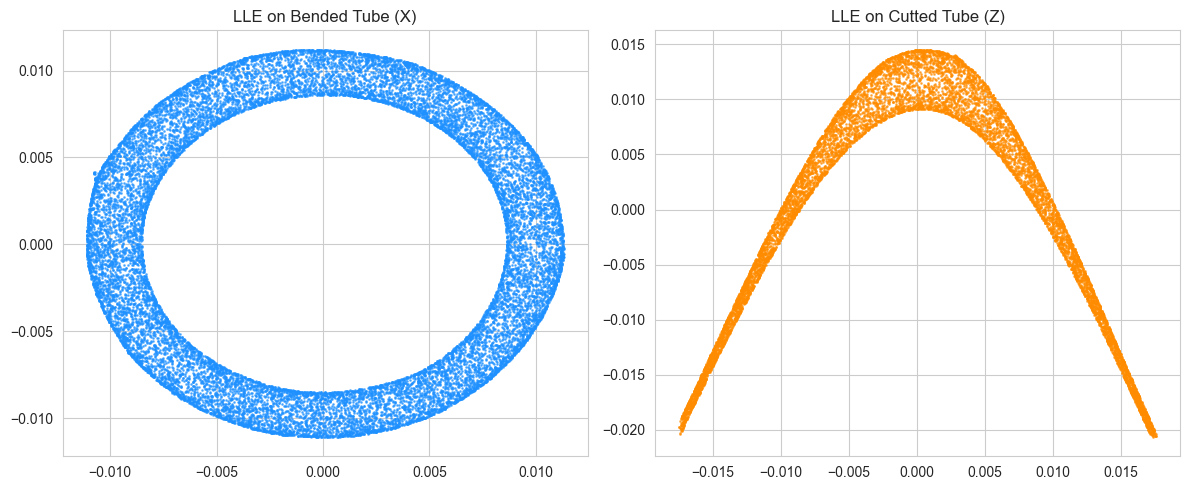

In [23]:
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt

# Apply LLE to both datasets
lle = LocallyLinearEmbedding(n_neighbors=12, n_components=2, method='standard', random_state=42)

X_lle = lle.fit_transform(X_20000)
Z_lle = lle.fit_transform(X_10000)

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X_lle[:, 0], X_lle[:, 1], c='dodgerblue', s=1, alpha=0.6)
axs[0].set_title("LLE on Bended Tube (X)")

axs[1].scatter(Z_lle[:, 0], Z_lle[:, 1], c='darkorange', s=1, alpha=0.6)
axs[1].set_title("LLE on Cutted Tube (Z)")

plt.tight_layout()
plt.savefig('9_b', bbox_inches='tight')
plt.show()


9(c)

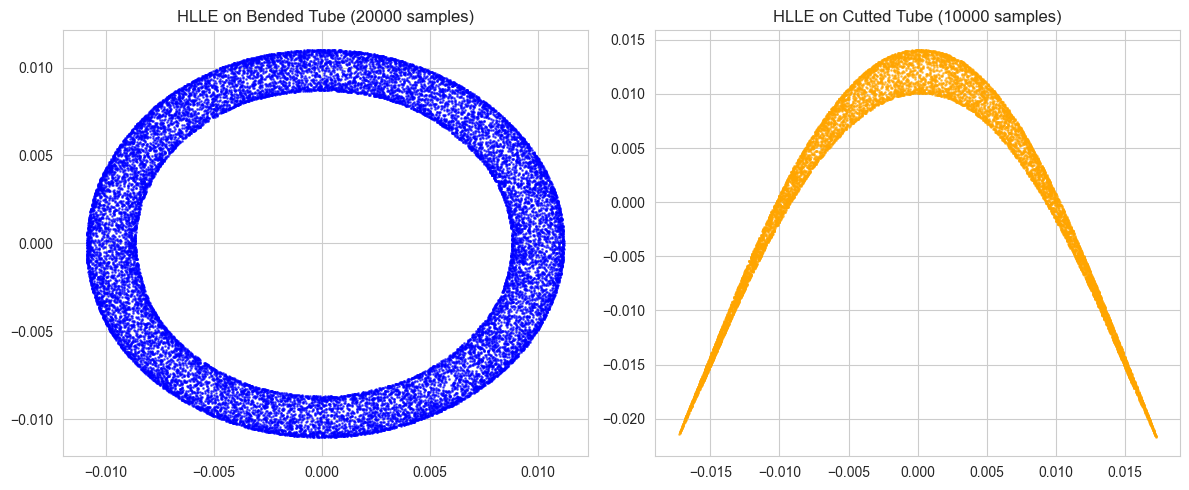

In [24]:
# Apply HLLE to both datasets
hlle = LocallyLinearEmbedding(n_neighbors=12, n_components=2, method='hessian', random_state=42)

X_hlle = hlle.fit_transform(X_20000)
Z_hlle = hlle.fit_transform(X_10000)

# Plot the HLLE projections
_, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X_hlle[:, 0], X_hlle[:, 1], c='blue', s=1, alpha=0.6)
axs[0].set_title("HLLE on Bended Tube (20000 samples)")

axs[1].scatter(Z_hlle[:, 0], Z_hlle[:, 1], c='orange', s=1, alpha=0.6)
axs[1].set_title("HLLE on Cutted Tube (10000 samples)")

plt.tight_layout()
plt.savefig('9_c', bbox_inches='tight')
plt.show()

Question-10: SMACOF and Minkowski Distance on Leukemia Dataset

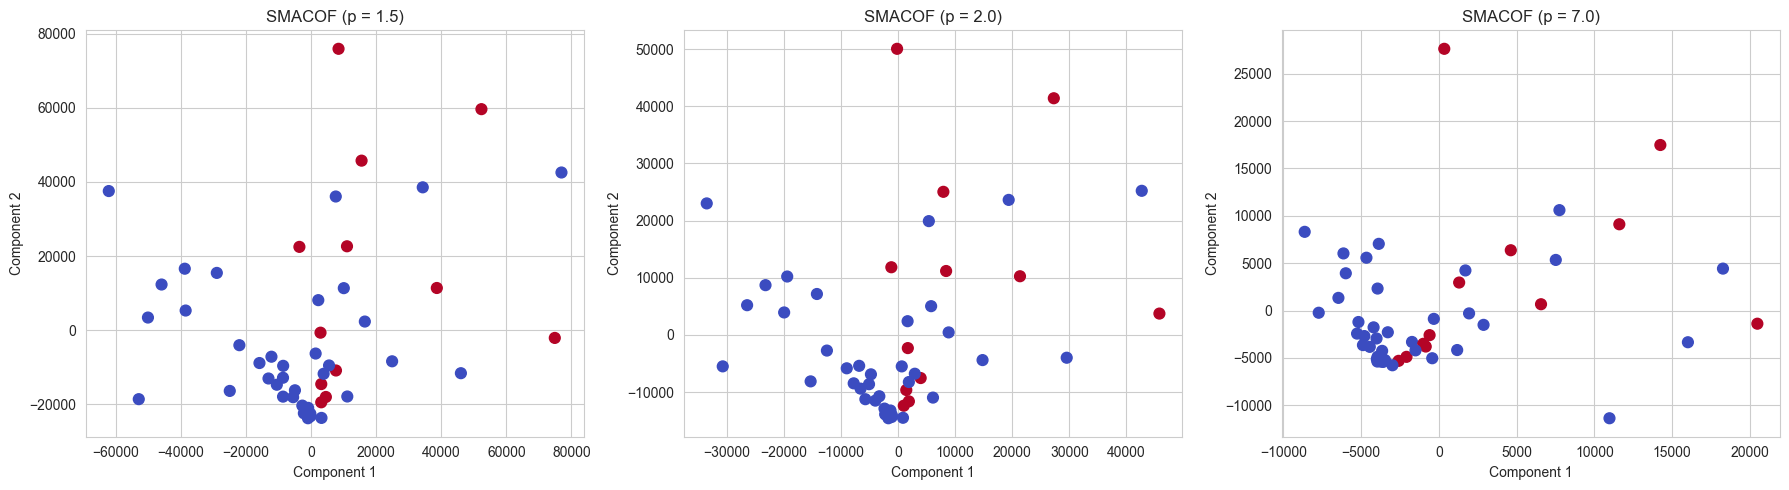

In [25]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from scipy.spatial.distance import pdist, squareform

# Load dataset
data = scipy.io.loadmat("leukemia.mat")
X_raw = data['leukemia']
label_array = np.array(data['cancertype']).squeeze()
fixed_labels = [str(label[0]) for label in label_array[:X_raw.shape[0]]]
label_colors = np.array([0 if l == 'ALL' else 1 for l in fixed_labels])

# SMACOF scratch
def smacof(dissimilarities, n_components=2, max_iter=300, eps=1e-6, random_state=None):
    n = dissimilarities.shape[0]
    rs = check_random_state(random_state)
    X = rs.rand(n, n_components)
    stress = None

    for i in range(max_iter):
        dist = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
        dist[dist == 0] = 1e-5
        B = -dissimilarities / dist
        np.fill_diagonal(B, -B.sum(axis=1))
        X_new = (1 / n) * B @ X
        stress_new = ((dissimilarities - dist)**2).sum() / 2
        if stress is not None and abs(stress - stress_new) < eps:
            break
        X = X_new
        stress = stress_new
    return X, stress

# Wrapper using Minkowski distance
def run_smacof_with_minkowski(X, p, **kwargs):
    D = squareform(pdist(X, metric='minkowski', p=p))
    return smacof(D, **kwargs)

# Run SMACOF for different p-values
X_15, stress_15 = run_smacof_with_minkowski(X_raw, p=1.5, n_components=2, random_state=42)
X_2,  stress_2  = run_smacof_with_minkowski(X_raw, p=2.0, n_components=2, random_state=42)
X_7,  stress_7  = run_smacof_with_minkowski(X_raw, p=7.0, n_components=2, random_state=42)

# Plotting
_, axs = plt.subplots(1, 3, figsize=(18, 5))

def plot_embedding(ax, X, title):
    ax.scatter(X[:, 0], X[:, 1], c=label_colors, cmap='coolwarm', s=60)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True)

plot_embedding(axs[0], X_15, "SMACOF (p = 1.5)")
plot_embedding(axs[1], X_2,  "SMACOF (p = 2.0)")
plot_embedding(axs[2], X_7,  "SMACOF (p = 7.0)")
plt.tight_layout()
plt.savefig('q_10', bbox_inches='tight')
plt.show()
